# Money Management: Monte Carlo Markov Chain

In money management, an important practice is to conduct simulations so that we are equipped with some expectation of what is going to happen in the future. This way we are not completely surprised and we have plans to execute. 

In statistics, Markov Chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. In this notebook, I adopt this philosphy and I come up with a cute practice of how this MCMC idea can be applied. In brief, I cover the following steps:

- $\textbf{Environment Initiation}$. I always start with initiating the environment. I import the correct modules, APIs, and libraries that need to be used for this notebook and I set up my data set.

- $\textbf{Data Cleanup}$. Data set cleanup is very important. In real world, not all data are saved properly and it is our duty as a data scientist and machine learning practitioner to ensure that the data is valid and can be processed by machines.

- $\textbf{MCMC Simulation}$. I conduct MCMC simulation by generating approximations of cumulative stock returns using parameters known from data source. I land on visualization of what the simulated parallel performances look like on chart. 

- $\textbf{Software Development / Product Management}$. Every data science project has two phases. Phase I is about end-to-end research and select the most optimal machine learning procedure. Phase II is about delivering a software product to consumer and clients so that the python codes can be called and there is no need to redo everything that has already been done.

## Environment Initiation

Let us start this notebook by importing all the libraries we need.

In [87]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf

I code a helper function here called *getDatafromYF* that is a function defined using *yf.download* from *yfinance* library.

In [2]:
# Define function
def getDatafromYF(ticker, start_date, end_date):
    stockData = yf.download(ticker, start_date, end_date)
    return stockData
# End function

## Data Cleanup

Data set clean up is important. It is our job as data scientist or machine learning practitioner to ensure the validity of the data set.

In [93]:
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2019-12-6')
tickers = ['AAPL']

# Start with Dictionary (this is where data is saved)
stockData = {}
for i in tickers:
    stockData[i] = pd.DataFrame(getDatafromYF(str(i), start_date, end_date))
    close = stockData[i]['Adj Close']
    stockData[i]['Normalize Return'] = close / close.shift() - 1

# Take a look
print(stockData[tickers[0]].head(3)) # this is desired stock

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2013-01-02  79.117142  79.285713  77.375717  78.432854  68.850548  140129500   
2013-01-03  78.268570  78.524284  77.285713  77.442856  67.981491   88241300   
2013-01-04  76.709999  76.947144  75.118568  75.285713  66.087891  148583400   

            Normalize Return  
Date                          
2013-01-02               NaN  
2013-01-03         -0.012622  
2013-01-04         -0.027855  


We have the data loaded above and I plot the data using time-series plot.

Text(0.5,1,'Cumulative Return')

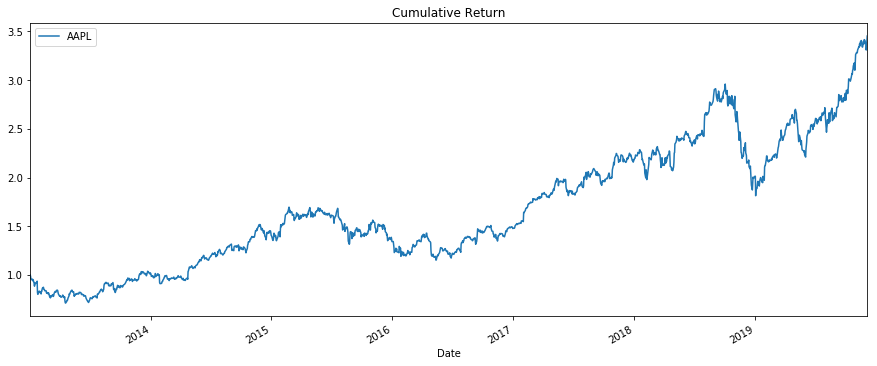

In [4]:
target = stockData[tickers[0]]
benchmark = stockData[tickers[1]]
target['Cumulative'] = target['Close'] / target['Close'].iloc[0]
target['Cumulative'].plot(label=tickers[0], figsize = (15,6))
plt.legend()
plt.title('Cumulative Return')

## MCMC Simulation

In statistics, Markov chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The more steps that are included, the more closely the distribution of the sample matches the actual desired distribution. 

In this practiice, I look at downloaded live data and I compute average stock returns and volatility (measured by standard deviation of stock returns). I treat these two metrics as inputs of the parameters I need for normal distribution. Next, I resample many times from the same distribution with the same parameters introduced. I land on a visualization of how all these resampled distribution look like and how they can impact business performance.

In mathematical form, I introduce normal distribution with parameters that are computed from data
$$\mathcal{N}(\mu, \sigma) \sim \mathcal{N}(\mathbb{E}(X), \hat{\sigma(X)})$$
while $X$ is the array of stock returns obtained from live data and $\hat{\sigma(X)}$ is the estimated standard deviation of $X$.

In [26]:
averageReturn = (stockData[tickers[0]].iloc[:, 6]).mean()
Volatility = (stockData[tickers[0]].iloc[:, 6]).std()
print('Expected Return is ', averageReturn, '\nVolatility is ', Volatility)

Expected Return is  0.0009096389567263054 
Volatility is  0.015761665964167965


In [84]:
# Approximate with Normal Distribution
#     note: we do not predefine parameters, we let the data tell us what the parameters are
#           we assume these parameters are robust under LLN
Z = np.random.normal(averageReturn, Volatility, (250, 10))
S = np.zeros_like(Z)
S[0] = target['Cumulative'].iloc[-1]
for t in range(1, len(S)):
    S[t] = S[t-1] * (Z[t-1] + 1)

In [85]:
print(S.shape, '\n', S)

(250, 10) 
 [[3.45148721 3.45148721 3.45148721 ... 3.45148721 3.45148721 3.45148721]
 [3.40828467 3.46380456 3.4522691  ... 3.44813193 3.46419118 3.51597071]
 [3.38598681 3.40913286 3.41737497 ... 3.52178265 3.37582808 3.49581289]
 ...
 [2.68421213 4.77080598 3.01272815 ... 3.14561408 3.52584827 4.58523401]
 [2.68563841 4.77134915 3.05720912 ... 3.09883144 3.62474071 4.55180862]
 [2.67674111 4.76596459 3.14003195 ... 3.08821185 3.63519875 4.55236899]]


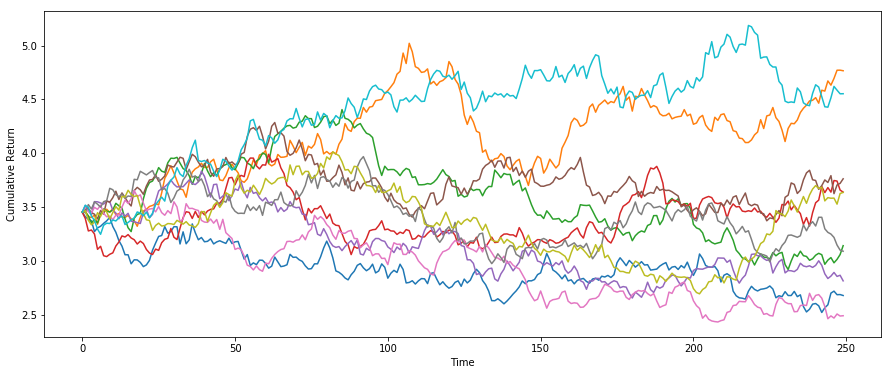

In [86]:
plt.figure(figsize=(15,6))
plt.plot(S[:, :10])
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

## Software Development / Product Management

From about analysis, we have established a list of steps we execute to carry out a simple linear regression analysis. Each step is clear written and can be examined for reference. 

Now it is time to pack everything together into a function so that the above analysis can be summarized into a word and can be pulled for future usage without having to code everything again. Once this software is developed we can get the product shipped to employers or clients and we will be starting negotiation as well as software maintainance (which is crucial for product management)

In [118]:
# Define function
def MM_MCMC(tickers, start_date, end_date, total_length, num_of_simulatition, plot_stock_return, plot_simulatiions):
    # Environment Initiation
    import numpy as np
    import pandas as pd
    from pandas_datareader import data as web
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    import yfinance as yf
    
    # Helper Function
    # Define function
    def getDatafromYF(ticker, start_date, end_date):
        stockData = yf.download(ticker, start_date, end_date)
        return stockData
    # End function
    
    # Get Data
    # Start with Dictionary (this is where data is saved)
    stockData = {}
    for i in tickers:
        stockData[i] = pd.DataFrame(getDatafromYF(str(i), start_date, end_date))
        close = stockData[i]['Adj Close']
        stockData[i]['Normalize Return'] = close / close.shift() - 1

    # Visualization
    target = stockData[tickers[0]]
    target['Cumulative'] = target['Close'] / target['Close'].iloc[0]
    averageReturn = (stockData[tickers[0]].iloc[:, 6]).mean()
    Volatility = (stockData[tickers[0]].iloc[:, 6]).std()
    if plot_stock_return == True:
        target['Cumulative'].plot(label=tickers[0], figsize = (15,6))
        plt.legend()
        plt.title('Cumulative Return of Historical Data (up to date)' + 
                  '\nTotal Observations: ' + str(len(target)) +
                  '\nAverage Returns: ' + str(round(averageReturn, 4)) +
                  '\nVolatility (measured by Standard Deviation of Returns): ' + str(round(Volatility, 4)))

    # MCMC
    # Approximate with Normal Distribution
    #     note: we do not predefine parameters, we let the data tell us what the parameters are
    #           we assume these parameters are robust under LLN
    Z = np.random.normal(averageReturn, Volatility, (total_length, num_of_simulatition))
    S = np.zeros_like(Z)
    S[0] = target['Cumulative'].iloc[-1]
    for t in range(1, len(S)):
        S[t] = S[t-1] * (Z[t-1] + 1)

    # Visualization
    if plot_simulatiions == True:
        plt.figure(figsize=(15,6))
        plt.plot(S[:, :num_of_simulatition])
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return')
        plt.title(
            'Graphical Visualization of Potential Incoming Scenarios (MCMC):' +
            '\nNumber of Length Simulated: ' + str(total_length) +
            '\nNumber of Paths Siimulated: ' + str(num_of_simulatition))
        plt.show()
    
    # Output
    return {
        'Data': stockData[tickers[0]],
        'newData': target,
        'Expected Return': averageReturn,
        'Volatility': Volatility
    }
# End of function

The goal is conduct more efficient data analysis and visualization work for clients. With the functions written above, it is much more efficient to turn what we have into a software 

[*********************100%***********************]  1 of 1 completed


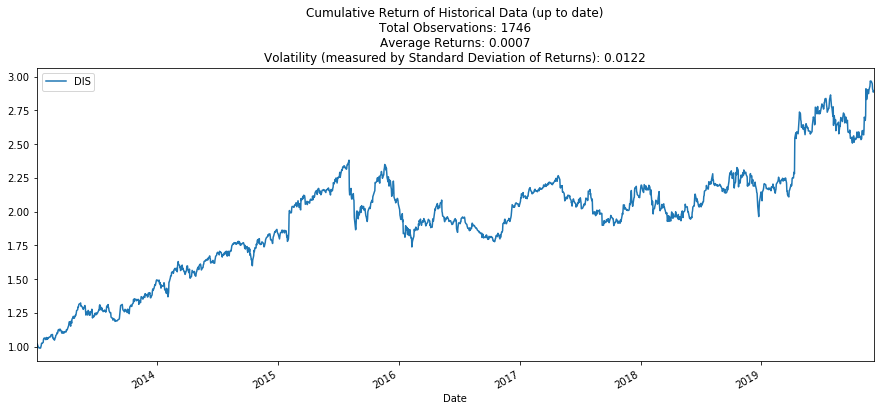

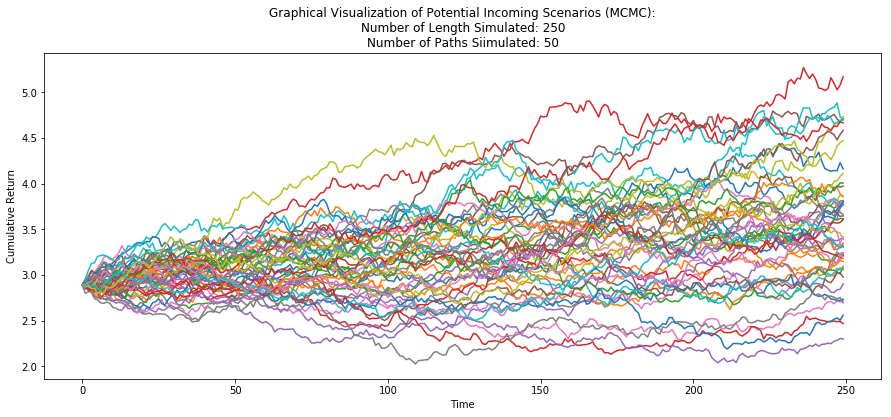

In [120]:
# What Do You Want?
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2019-12-6')
ticker = ['DIS']

# Run
testresult = MM_MCMC(ticker, start_date, end_date, 250, 50, True, True)